Part 2: Image Mosaics (Image stitching of two images)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/assig2_cv

/content/drive/MyDrive/Colab Notebooks/assig2_cv


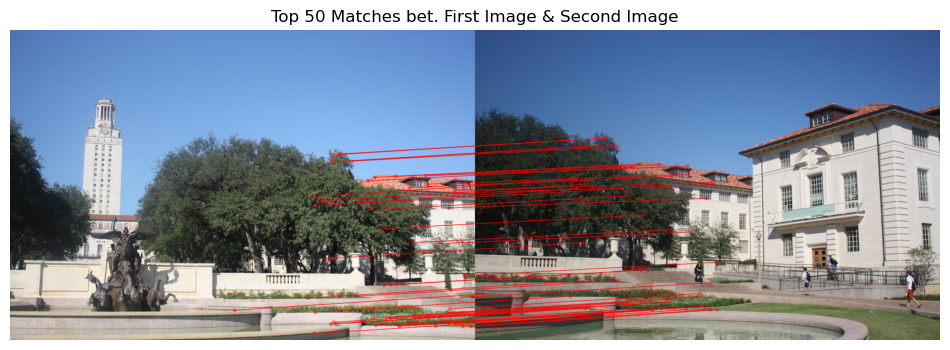

In [2]:
# Step 1: Load the book image and the first frame of the book video
img2 = cv2.cvtColor(cv2.imread('assig2_cv_mats/pano_image1.jpg'), cv2.COLOR_BGR2RGB) #Left
img1 = cv2.cvtColor(cv2.imread('assig2_cv_mats/pano_image2.jpg'), cv2.COLOR_BGR2RGB) #Right

# Step 2: Initialize the SIFT detector
sift = cv2.SIFT_create()

# Step 3: Detect keypoints and descriptors
keypts_img1, descriptors_img1 = sift.detectAndCompute(img1, None)
keypts_img2, descriptors_img2 = sift.detectAndCompute(img2, None)

# Step 4: Use a Brute-Force Matcher with KNN
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

# Step 5: Perform KNN matching with ratio test
matches = bf.knnMatch(descriptors_img1, descriptors_img2, k=2)

# Step 6: Apply ratio test to choose best 50 matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
good_matches = sorted(good_matches, key=lambda x: x.distance)[:50]

# Step 7: Draw the matches on the images
img_matches = cv2.drawMatches(
    img1, keypts_img1, img2, keypts_img2,
    good_matches, None, matchColor=(255,0,0),
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Step 8: Plot the results
plt.figure(figsize=(12, 12))
plt.imshow(img_matches)
plt.title('Top 50 Matches bet. First Image & Second Image')
plt.axis('off')
plt.show()

Computed Homography Matrix:
 [[ 1.32507305e+00 -7.42068193e-02 -5.88740105e+02]
 [ 1.77335096e-01  1.24322553e+00 -1.76688116e+02]
 [ 2.97310501e-04  3.16228572e-05  1.00000000e+00]]


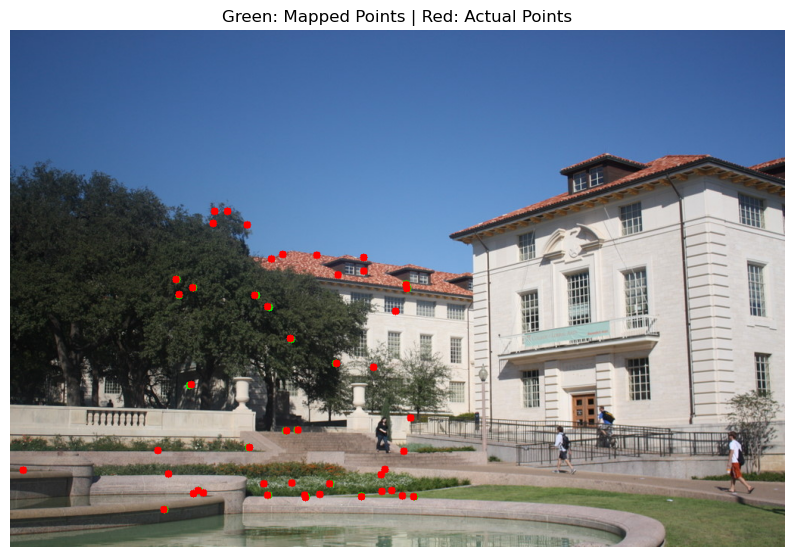

In [3]:
# Step 9: Build function to compute Homography matrix using DLT
def compute_homography(src_pts, dst_pts):
    """
    Compute Homography Matrix H such that dst_pts ≈ H * src_pts
    src_pts: (N, 2) → points from book_img
    dst_pts: (N, 2) → points from video frame
    Compute Homography H using Ax = b, with 8 unknowns & H[3,3] = 1
    """
    assert src_pts.shape[0] >= 4, "Requires at least 4 point correspondences"
    N = src_pts.shape[0]
    A = []

    for i in range(N):
        x, y = src_pts[i]
        x_d, y_d = dst_pts[i]
        # For x' equation (first part of the system)
        A.append([x, y, 1, 0, 0, 0, -x * x_d, -y * x_d, -x_d])
        # For y' equation (second part of the system)
        A.append([0, 0, 0, x, y, 1, -x * y_d, -y * y_d, -y_d])

    #2Nx8 coefficient matrix
    A = np.array(A)
    # Solve using SVD
    U, S, Vt = np.linalg.svd(A)
    # Get the smallest singular value (last row of V transposed)
    h = Vt[-1, :]
    # Reshape to get 3x3 homography matrix
    H = h.reshape((3, 3))
    # Normalize so H[2,2] = 1
    H = H / H[2, 2]
    return H

# Step 10: Extract Point Correspondences from Good Matches
src_pts = np.array([keypts_img1[m.queryIdx].pt for m in good_matches])
dst_pts = np.array([keypts_img2[m.trainIdx].pt for m in good_matches])

# Step 11:Compute the Homography matrix H using p & p'
H = compute_homography(src_pts, dst_pts)
print("Computed Homography Matrix:\n", H)

# Step 12: Verify H by Mapping Book Points to Video Frame
#Convert src_pts to homogeneous coordinates
src_pts_hom = np.hstack((src_pts, np.ones((src_pts.shape[0], 1))))
#Map points using the computed Homography matrix H
mapped_pts_hom = (H @ src_pts_hom.T).T
#Normalize
mapped_pts = mapped_pts_hom[:, :2] / mapped_pts_hom[:, 2, np.newaxis]

# Step 13: Visualize the verification test on first_frame
frame_vis = img2.copy()
#Green for mapped points (predicted)
for p in mapped_pts:
    cv2.circle(frame_vis, (int(p[0]), int(p[1])), 5, (0, 255, 0), -1)
#Red for actual points (measured)
for p in dst_pts:
    cv2.circle(frame_vis, (int(p[0]), int(p[1])), 5, (255, 0, 0), -1)
plt.figure(figsize=(10, 8))
plt.imshow(frame_vis)
plt.title('Green: Mapped Points | Red: Actual Points')
plt.axis('off')
plt.show()

In [4]:
def warp_image(img, H, output_shape):
    """
    Warps img using homography H onto the coordinate frame defined by output_shape
        img: Input image (H x W x 3)
        H: Homography matrix (3 x 3)
        output_shape: Tuple (height, width) of the output warped image
        Warped image aligned to output frame is returned
    """
    h_out, w_out = output_shape
    H_inv = np.linalg.inv(H)

    # Create a meshgrid of (x, y) coordinates in the output image
    x_out, y_out = np.meshgrid(np.arange(w_out), np.arange(h_out))
    ones = np.ones_like(x_out)

    coords_out = np.stack([x_out, y_out, ones], axis=-1).reshape(-1, 3).T  # 3xN size

    # Apply inverse homography to find corresponding points in the source image
    coords_src = H_inv @ coords_out

    # Normalize
    coords_src /= coords_src[2, :]
    x_src = coords_src[0, :].reshape(h_out, w_out)
    y_src = coords_src[1, :].reshape(h_out, w_out)

    # Use cv2.remap for bilinear interpolation
    map_x = x_src.astype(np.float32)
    map_y = y_src.astype(np.float32)

    # Apply edge padding using cv2.BORDER_REPLICATE
    warped_channels = []
    for i in range(3):  # For each RGB channel
        warped = cv2.remap(img[:, :, i], map_x, map_y,
                           interpolation=cv2.INTER_LINEAR,
                           borderMode=cv2.BORDER_REPLICATE)
        warped_channels.append(warped)

    # Stack the channels to form the final warped image
    warped_img = np.stack(warped_channels, axis=-1)

    return warped_img

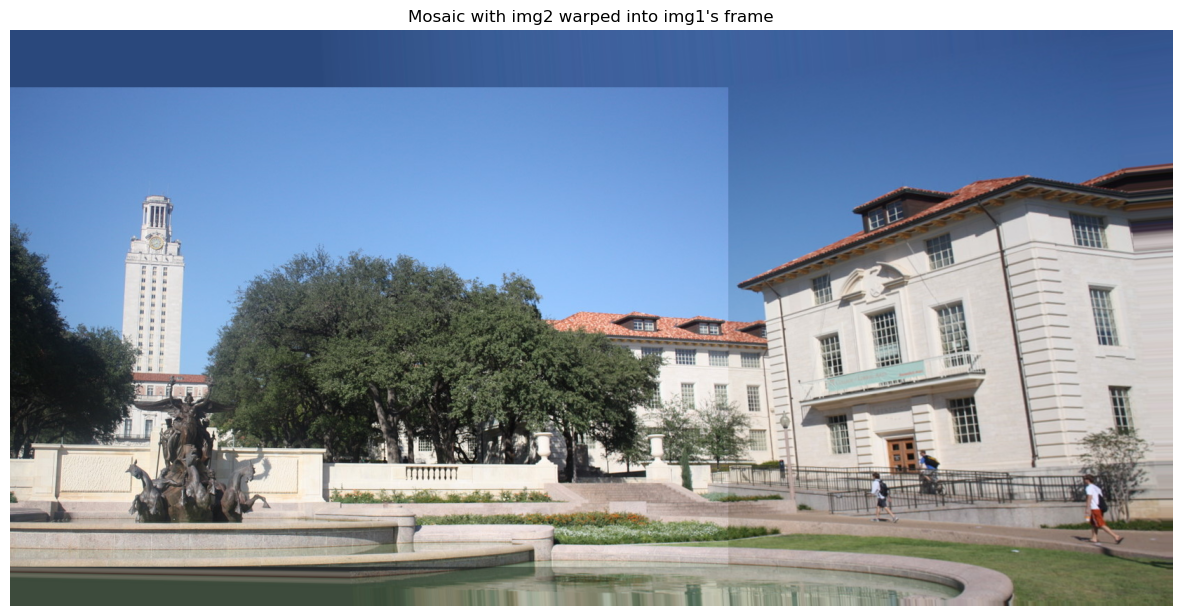

In [5]:
def create_two_image_mosaic_reverse(img1, img2, H):
    """
    Warps img2 into img1's coordinate frame and creates a mosaic.
        img1: source image (reference)
        img2: destination image (to be warped)
        H: homography from img1 to img2 >> img2 = H @ img1
        mosaic: stitched image mosaic with img1 unchanged & img2 warped
    """
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Get corners of img2 (for warping)
    corners_img2 = np.array([
        [0, 0],
        [w2, 0],
        [w2, h2],
        [0, h2]
    ], dtype=np.float32)

    # Warp corners of img2 into img1's space (by applying the inverse of H)
    H_inv = np.linalg.inv(H)
    corners_img2_homog = cv2.perspectiveTransform(corners_img2[None, :, :], H_inv)[0]

    # Get Corners of img1
    corners_img1 = np.array([
        [0, 0],
        [w1, 0],
        [w1, h1],
        [0, h1]
    ], dtype=np.float32)

    # Combine and find bounding box
    all_corners = np.vstack((corners_img2_homog, corners_img1))
    [xmin, ymin] = np.floor(all_corners.min(axis=0)).astype(int)
    [xmax, ymax] = np.ceil(all_corners.max(axis=0)).astype(int)

    # Translation offset to avoid negative coordinates
    tx, ty = -xmin, -ymin
    translation = np.array([[1, 0, tx],
                            [0, 1, ty],
                            [0, 0, 1]])

    # Warp img2 into this output shape calculated
    output_shape = (ymax - ymin, xmax - xmin)
    warped_img2 = warp_image(img2, translation @ H_inv, output_shape)

    # Paste img1 into the mosaic (no warping needed for img1)
    mosaic = warped_img2.copy()
    mosaic[ty:ty+h1, tx:tx+w1] = img1  # overlay img1 in its original location
    return mosaic


# Assuming img1, img2, and H are already defined
mosaic = create_two_image_mosaic_reverse(img1, img2, H)

# Show the mosaic
plt.figure(figsize=(15, 8))
plt.imshow(mosaic)
plt.title('Mosaic with img2 warped into img1\'s frame')
plt.axis('off')
plt.show()